In [114]:
from __future__ import print_function
import argparse
import copy
import nltk
import threading

import numpy as np
from rdkit import Chem
from rdkit import rdBase

import cfg_util
import score_util
import zinc_grammar

rdBase.DisableLog('rdApp.error')

In [126]:
import turtle

In [115]:
#GCFG = nltk.CFG.fromstring(gram)
GCFG = zinc_grammar.GCFG

In [116]:
GCFG

<Grammar with 74 productions>

In [117]:
def CFGtoGene(prod_rules, max_len=-1):
    gene = []
    for r in prod_rules:
        lhs = GCFG.productions()[r].lhs()
        possible_rules = [idx for idx, rule in enumerate(GCFG.productions())
                          if rule.lhs() == lhs]
        gene.append(possible_rules.index(r))
    if max_len > 0:
        if len(gene) > max_len:
            gene = gene[:max_len]
        else:
            gene = gene + [np.random.randint(0, 256)
                           for _ in range(max_len-len(gene))]
    return gene


def GenetoCFG(gene):
    prod_rules = []
    stack = [GCFG.productions()[0].lhs()]
    for g in gene:
        try:
            lhs = stack.pop()
        except Exception:
            break
        possible_rules = [idx for idx, rule in enumerate(GCFG.productions())
                          if rule.lhs() == lhs]
        rule = possible_rules[g % len(possible_rules)]
        prod_rules.append(rule)
        rhs = filter(lambda a: (type(a) == nltk.grammar.Nonterminal)
                     and (str(a) != 'None'),
                     zinc_grammar.GCFG.productions()[rule].rhs())
        stack.extend(list(rhs)[::-1])
    return prod_rules


def mutation(gene):
    idx = np.random.choice(len(gene))
    gene_mutant = copy.deepcopy(gene)
    gene_mutant[idx] = np.random.randint(0, 256)
    return gene_mutant


def canonicalize(smiles):
    mol = Chem.MolFromSmiles(smiles)
    if smiles != '' and mol is not None and mol.GetNumAtoms() > 1:
        return Chem.MolToSmiles(mol)
    else:
        return smiles

In [118]:
elapsed_min = 0
best_score = 0
mean_score = 0
std_score = 0
min_score = 0
best_smiles = ""
all_smiles = []

In [11]:
parser = argparse.ArgumentParser()
parser.add_argument('--smifile', default='250k_rndm_zinc_drugs_clean.smi')
parser.add_argument('--seed', type=int, default=0)
args = parser.parse_known_args()

# global best_smiles
# global best_score
# global all_smiles

# gene_length = 300

# N_mu = 100
# N_lambda = 200

In [12]:
args

(Namespace(seed=0, smifile='250k_rndm_zinc_drugs_clean.smi'),
 ['-f',
  '/Users/yweilin/Library/Jupyter/runtime/kernel-9bf330ed-1453-43ce-b22f-14a166c24c78.json'])

In [19]:
seed_smiles = []
with open('250k_rndm_zinc_drugs_clean.smi') as f:
    for line in f:
        smiles = line.rstrip()
        seed_smiles.append(smiles)

In [21]:
len(seed_smiles)

249456

In [119]:
seed_smiles[11]

'Cc1ccc2nc(S[C@H](C)C(=O)NC3CCC(C)CC3)n(C)c(=O)c2c1'

In [120]:
N_mu = 100
N_lambda = 200
gene_length = 300

In [121]:
initial_smiles = np.random.choice(seed_smiles, N_mu+N_lambda)
initial_smiles = [canonicalize(s) for s in initial_smiles]
initial_genes = [CFGtoGene(cfg_util.encode(s), max_len=gene_length) for s in initial_smiles]
initial_scores = [score_util.calc_score(s) for s in initial_smiles]

In [124]:
try_smi= 'O=C(OCCCCOCCCCOCCCCOCCCCOC(Nc1ccc(Cc2ccc(NC(C)=O)cc2)cc1)=O)Nc3ccc(Cc4ccc(NC(OCCNC5=NC(NCCOC(Nc6ccc(Cc7ccc(NC(OCCCCOCCCCOCCCCOC)=O)cc7)cc6)=O)=NC(NCCOC(Nc8ccc(Ccccc(NC(OCCCCOCCCCOCCCCOCCCCOCCCCOC)=O)cc)cc8)=O)=N5)=O)cc4)cc3'
try_gene = CFGtoGene(cfg_util.encode(try_smi), max_len=gene_length)

In [125]:
try_gene

[0,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 2,
 0,
 0,
 1,
 3,
 1,
 2,
 1,
 1,
 1,
 0,
 2,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 0,
 1,
 3,
 0,
 1,
 1,
 0,
 1,
 1,
 0,
 1,
 1,
 0,
 1,
 1,
 0,
 1,
 3,
 0,
 1,
 1,
 0,
 1,
 1,
 0,
 1,
 1,
 0,
 1,
 1,
 0,
 1,
 3,
 0,
 1,
 1,
 0,
 1,
 1,
 0,
 1,
 1,
 0,
 1,
 1,
 0,
 1,
 3,
 0,
 1,
 1,
 0,
 1,
 1,
 0,
 1,
 1,
 0,
 1,
 1,
 0,
 1,
 3,
 2,
 1,
 1,
 1,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 0,
 1,
 2,
 1,
 2,
 0,
 1,
 0,
 0,
 0,
 2,
 0,
 0,
 2,
 0,
 2,
 2,
 0,
 1,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 0,
 1,
 1,
 1,
 2,
 0,
 1,
 0,
 1,
 0,
 2,
 0,
 0,
 2,
 0,
 2,
 2,
 0,
 1,
 0,
 2,
 1,
 0,
 0,
 1,
 2,
 2,
 1,
 1,
 1,
 0,
 0,
 0,
 1,
 1,
 1,
 0,
 1,
 3,
 0,
 2,
 0,
 1,
 2,
 0,
 1,
 0,
 1,
 0,
 2,
 0,
 1,
 2,
 0,
 1,
 0,
 0,
 1,
 0,
 1,
 3,
 0,
 1,
 2,
 1,
 2,
 0,
 1,
 0,
 2,
 0,
 2,
 0,
 0,
 2,
 0,
 2,
 2,
 0,
 1,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 0,
 1,
 1,
 1,
 2,
 0,
 1,
 0,
 3,
 0,
 2,
 0,
 0,
 2,
 0,
 2,
 2,
 0,


In [105]:
len(initial_genes[0])

300

In [31]:
population = []
for score, gene, smiles in zip(initial_scores, initial_genes,initial_smiles):
    population.append((score, smiles, gene))

In [ ]:
##

In [50]:
def get_zinc_tokenizer(cfg):
    long_tokens = [a for a in cfg._lexical_index.keys() if len(a) > 1]
    replacements = ['$', '%', '^']
    assert len(long_tokens) == len(replacements)
    for token in replacements:
        assert token not in cfg._lexical_index

    def tokenize(smiles):
        for i, token in enumerate(long_tokens):
            smiles = smiles.replace(token, replacements[i])
        tokens = []
        for token in smiles:
            try:
                ix = replacements.index(token)
                tokens.append(long_tokens[ix])
            except Exception:
                tokens.append(token)
        return tokens
    return tokenize

In [53]:
seed_smiles[11]

'Cc1ccc2nc(S[C@H](C)C(=O)NC3CCC(C)CC3)n(C)c(=O)c2c1'

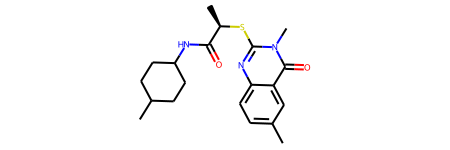

In [55]:
Chem.MolFromSmiles(seed_smiles[11])

In [52]:
GCFG = zinc_grammar.GCFG
tokenize = get_zinc_tokenizer(GCFG)

<function __main__.get_zinc_tokenizer.<locals>.tokenize(smiles)>

In [65]:
tokens = tokenize('CC(=O)OC1=CC=CC=C1C(=O)O')

In [66]:
print(tokens)

['C', 'C', '(', '=', 'O', ')', 'O', 'C', '1', '=', 'C', 'C', '=', 'C', 'C', '=', 'C', '1', 'C', '(', '=', 'O', ')', 'O']


In [67]:
parser = nltk.ChartParser(GCFG)

In [68]:
parser

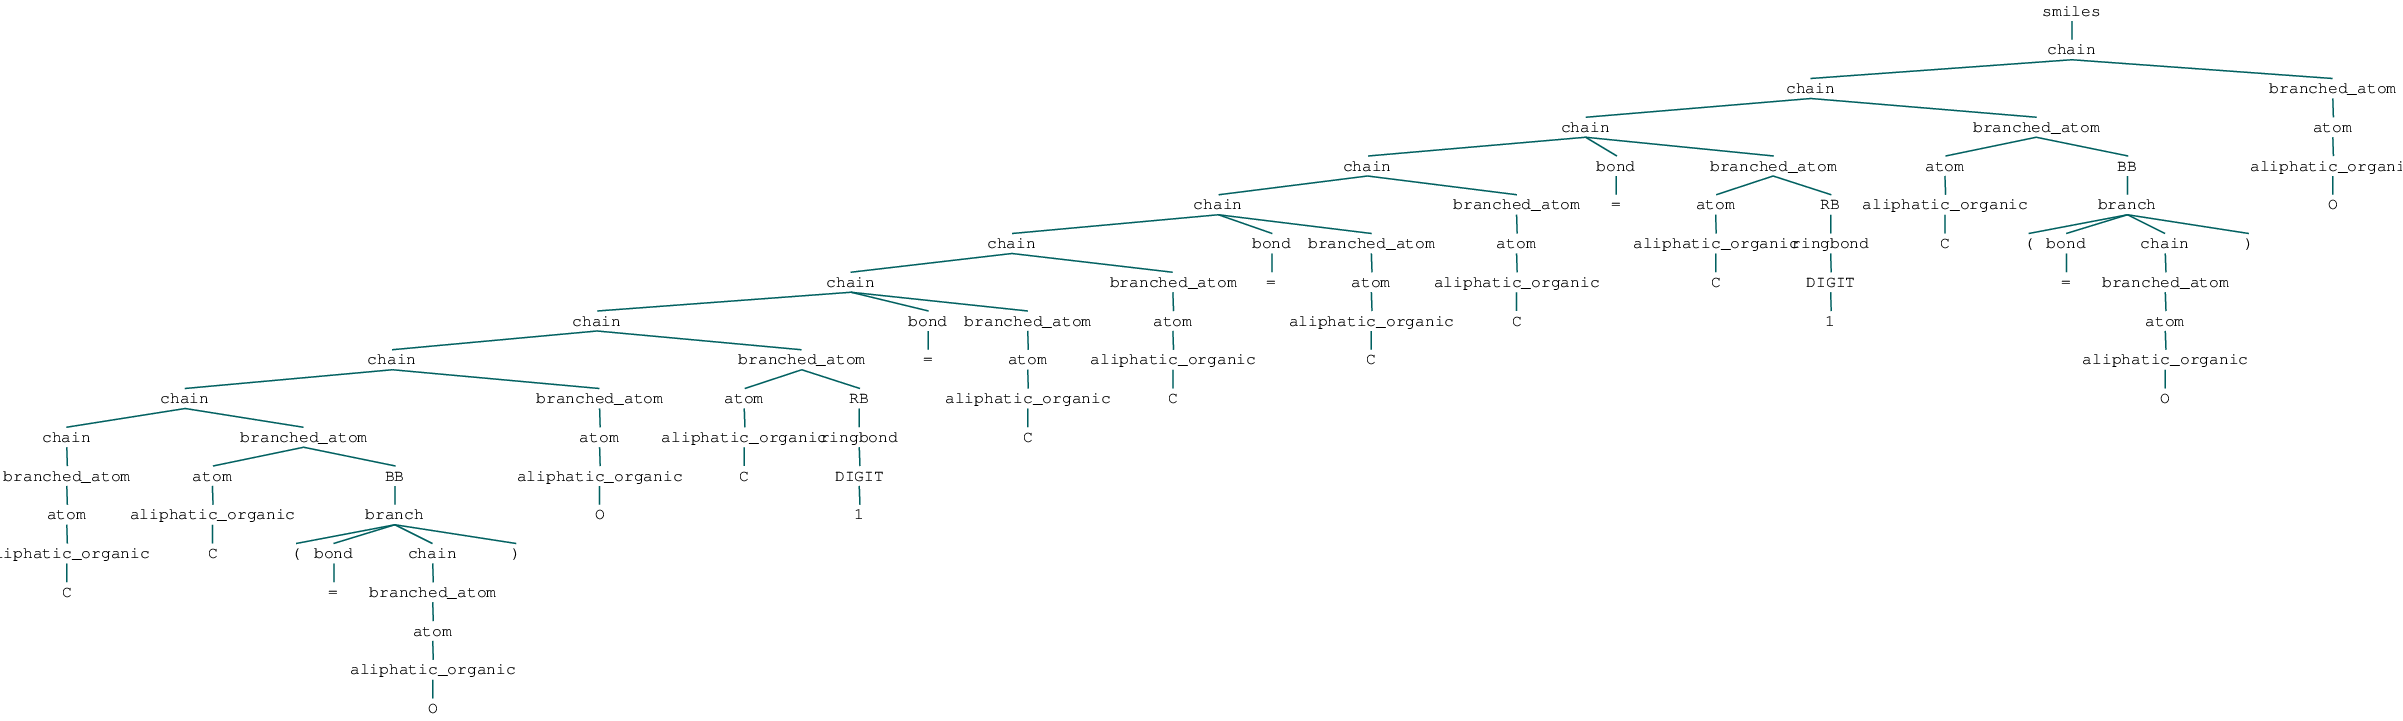

In [70]:
parse_tree = parser.parse('CC(=O)OC1=CC=CC=C1C(=O)O').__next__()
parse_tree

In [76]:
str(parse_tree)

'(smiles\n  (chain\n    (chain\n      (chain\n        (chain\n          (chain\n            (chain\n              (chain\n                (chain\n                  (chain\n                    (chain\n                      (chain\n                        (branched_atom (atom (aliphatic_organic C))))\n                      (branched_atom\n                        (atom (aliphatic_organic C))\n                        (BB\n                          (branch\n                            (\n                            (bond =)\n                            (chain\n                              (branched_atom\n                                (atom (aliphatic_organic O))))\n                            )))))\n                    (branched_atom (atom (aliphatic_organic O))))\n                  (branched_atom\n                    (atom (aliphatic_organic C))\n                    (RB (ringbond (DIGIT 1)))))\n                (bond =)\n                (branched_atom (atom (aliphatic_organic C))))\n    

In [ ]:
parse_tree.

In [88]:
productions_seq = parse_tree.productions()

In [83]:
productions = GCFG.productions()

In [84]:
productions

[smiles -> chain,
 atom -> bracket_atom,
 atom -> aliphatic_organic,
 atom -> aromatic_organic,
 aliphatic_organic -> 'B',
 aliphatic_organic -> 'C',
 aliphatic_organic -> 'N',
 aliphatic_organic -> 'O',
 aliphatic_organic -> 'S',
 aliphatic_organic -> 'P',
 aliphatic_organic -> 'F',
 aliphatic_organic -> 'I',
 aliphatic_organic -> 'Cl',
 aliphatic_organic -> 'Br',
 aromatic_organic -> 'c',
 aromatic_organic -> 'n',
 aromatic_organic -> 'o',
 aromatic_organic -> 's',
 bracket_atom -> '[' BAI ']',
 BAI -> isotope symbol BAC,
 BAI -> symbol BAC,
 BAI -> isotope symbol,
 BAI -> symbol,
 BAC -> chiral BAH,
 BAC -> BAH,
 BAC -> chiral,
 BAH -> hcount BACH,
 BAH -> BACH,
 BAH -> hcount,
 BACH -> charge,
 symbol -> aliphatic_organic,
 symbol -> aromatic_organic,
 isotope -> DIGIT,
 isotope -> DIGIT DIGIT,
 isotope -> DIGIT DIGIT DIGIT,
 DIGIT -> '1',
 DIGIT -> '2',
 DIGIT -> '3',
 DIGIT -> '4',
 DIGIT -> '5',
 DIGIT -> '6',
 DIGIT -> '7',
 DIGIT -> '8',
 chiral -> '@',
 chiral -> '@@',
 hcoun

In [85]:
prod_map = {}
for ix, prod in enumerate(productions):
    prod_map[prod] = ix

In [86]:
prod_map

{smiles -> chain: 0,
 atom -> bracket_atom: 1,
 atom -> aliphatic_organic: 2,
 atom -> aromatic_organic: 3,
 aliphatic_organic -> 'B': 4,
 aliphatic_organic -> 'C': 5,
 aliphatic_organic -> 'N': 6,
 aliphatic_organic -> 'O': 7,
 aliphatic_organic -> 'S': 8,
 aliphatic_organic -> 'P': 9,
 aliphatic_organic -> 'F': 10,
 aliphatic_organic -> 'I': 11,
 aliphatic_organic -> 'Cl': 12,
 aliphatic_organic -> 'Br': 13,
 aromatic_organic -> 'c': 14,
 aromatic_organic -> 'n': 15,
 aromatic_organic -> 'o': 16,
 aromatic_organic -> 's': 17,
 bracket_atom -> '[' BAI ']': 18,
 BAI -> isotope symbol BAC: 19,
 BAI -> symbol BAC: 20,
 BAI -> isotope symbol: 21,
 BAI -> symbol: 22,
 BAC -> chiral BAH: 23,
 BAC -> BAH: 24,
 BAC -> chiral: 25,
 BAH -> hcount BACH: 26,
 BAH -> BACH: 27,
 BAH -> hcount: 28,
 BACH -> charge: 29,
 symbol -> aliphatic_organic: 30,
 symbol -> aromatic_organic: 31,
 isotope -> DIGIT: 32,
 isotope -> DIGIT DIGIT: 33,
 isotope -> DIGIT DIGIT DIGIT: 34,
 DIGIT -> '1': 35,
 DIGIT -> 

In [89]:
indices = np.array([prod_map[prod] for prod in productions_seq], dtype=int)
print(indices)

[ 0 71 71 72 71 72 71 72 71 71 71 70 60  2  5 62  2  5 67 69 54 70 60  2
  7 60  2  7 61  2  5 65 58 35 54 60  2  5 60  2  5 54 60  2  5 60  2  5
 54 61  2  5 65 58 35 62  2  5 67 69 54 70 60  2  7 60  2  7]


In [90]:
len(indices)

68

In [91]:
indices

array([ 0, 71, 71, 72, 71, 72, 71, 72, 71, 71, 71, 70, 60,  2,  5, 62,  2,
        5, 67, 69, 54, 70, 60,  2,  7, 60,  2,  7, 61,  2,  5, 65, 58, 35,
       54, 60,  2,  5, 60,  2,  5, 54, 60,  2,  5, 60,  2,  5, 54, 61,  2,
        5, 65, 58, 35, 62,  2,  5, 67, 69, 54, 70, 60,  2,  7, 60,  2,  7])

In [ ]:
gene = []
for r in prod_rules:

In [95]:
productions[10]

aliphatic_organic -> 'F'

In [96]:
productions[10].lhs()

aliphatic_organic

In [99]:
for idx, rule in enumerate(productions[:10]):
    print(idx,rule)

0 smiles -> chain
1 atom -> bracket_atom
2 atom -> aliphatic_organic
3 atom -> aromatic_organic
4 aliphatic_organic -> 'B'
5 aliphatic_organic -> 'C'
6 aliphatic_organic -> 'N'
7 aliphatic_organic -> 'O'
8 aliphatic_organic -> 'S'
9 aliphatic_organic -> 'P'


In [ ]:
gene = []
    for r in prod_rules:
        lhs = GCFG.productions()[r].lhs()
        possible_rules = [idx for idx, rule in enumerate(GCFG.productions())
                          if rule.lhs() == lhs]
        gene.append(possible_rules.index(r))

In [ ]:
def CFGtoGene(prod_rules, max_len=-1):
    gene = []
    for r in prod_rules:
        lhs = GCFG.productions()[r].lhs()
        possible_rules = [idx for idx, rule in enumerate(GCFG.productions())
                          if rule.lhs() == lhs]
        gene.append(possible_rules.index(r))
    if max_len > 0:
        if len(gene) > max_len:
            gene = gene[:max_len]
        else:
            gene = gene + [np.random.randint(0, 256)
                           for _ in range(max_len-len(gene))]
    return gene

In [101]:
len(initial_smiles)

300